https://github.com/Student204161/computational-social-science-assignments
Part 1

### Contributions:
Each member of the group has participated equally on the project.

In [ ]:
from bs4 import BeautifulSoup ##A package to work with HTML data
import requests #A package to make HTTP requests

# Code to get the participants from the oral presentation
LINK = "https://2019.ic2s2.org/oral-presentations/"
r = requests.get(LINK)
soup = BeautifulSoup(r.content)
# find dev elements based on a specific class
div = soup.find("div",{"class":"col-md-8 page-content-wrap"})
div_p = div.find_all("p")[3:]
for d in div_p:
    d.strong.extract()

# Filter and clean diferent elements to get the participants
data = []
for d in div_p:
    output = d.get_text(strip=True,separator="\n").splitlines()[1:]
    for out in output:
        if out[0].isdigit():
            removed_date = list(filter(None, out.split("–")[2:]))[0]
            removed_topic = removed_date.split(".")[0]
            researchers = removed_topic.split(",")
            for r in researchers:
                data.append(r)
        elif out.split(": ")[0] == "Chair":
            data.append(out.split(": ")[1])

data_unique = list(set(data))

In [ ]:
# Code to get the participants from the posters
LINK = "https://2019.ic2s2.org/posters/"
r = requests.get(LINK)
soup = BeautifulSoup(r.content)
div = soup.find("div",{"class":"col-md-8 page-content-wrap"})
# Filter and clean diferent elements to get the participants
for child in div.find("ul").children:
    txt = child.get_text(strip=True,separator="\n").split("<span>")[0].split("\n")[0]
    txt = txt.replace(" and ", ", ")
    txt_split = txt.split(", ")
    for t in txt_split:
        data.append(t)
    print("-----------------------------------")
    print("child:")
    print(child)
data_unique = list(set(data))
while "" in data_unique:
    data_unique.remove("")

798 unique participants obtained in 2019.

## task 3 

Some of the elements had a different format compared to other elements.
e.g. could an element have the format {authorName} {subject}
but for some reason some elements(only 1 were manually found) were split in 2 as in element1: was the authername and the next element was the subject.
this would affect the code and make it more complicated to make. A decision was made to skip such elements.

# Part 2
The script was executed as a batch job using DTUs HPC. We scraped data from IC2S2 2019,2020 and 2021, and we included collaborators, which gave us a list of 38085 authorIds. However requesting some authorIds led to 504 errors (Request Timed Out), so only 25000~ authorIds was retrieved and used to generate a csv-files. 

Our final author dataframe is x long and our final paper dataframe is 2000000 long.


## 2020 IC2S2 Scraping

In [ ]:
url = "https://ic2s2.mit.edu/program"

LINK = "https://2019.ic2s2.org/posters/"
r = requests.get(LINK)

soup = BeautifulSoup(r.content,features="html.parser")

my_main = soup.find("div",{"class":"col-md-8 page-content-wrap"})

my_sections = soup.find_all('ul')
my_sections = my_sections[6:8]

name_list = []
for i in my_sections:
    sec_lines = i.find_all('li')
    for j in sec_lines:
        names_and_proj = j.get_text()
        names = names_and_proj.split('\xa0\n')[0].replace(' and ', ', ')
        names = names.split(', ')
        name_list.append(names)

import numpy as np
print(len(np.unique(name_list)))



## 2021 IC2S2 Scraping

In [ ]:
# 2021 
LINK = "https://easychair.org/smart-program/IC2S2-2021/talk_author_index.html"
r = requests.get(LINK) 
soup = BeautifulSoup(r.content)
table = soup.find("table",{"class":"index"})    
 # How many people there is in total
table_rows = table.find_all("tr")
rows = []
count = 0
for tr in table_rows[1:]:
    people = tr.find_all("td","name")
    for person in people:
        count += 1
        print(person.text)
print("Number of people:", count)

## Requesting Semantic Scholar API

In [11]:
from google.colab import drive
drive.mount('/content/my_drive', force_remount=True)

ids_list = list(np.load(r'/content/my_drive/MyDrive/computational_social_science/week2/author_ids.npy',allow_pickle=True))
print(len(ids_list))

Mounted at /content/my_drive
38085


The script is programmed to use checkpoints - If supplying a list of IDs that one is interested in, then the script will check response.json for IDs that have already been requested, meaning one is able to resume requests. First we have ran the program with chunk size 100, then 50, then 20 and 5 in order to avoid as many <500> errors as possible.

In [ ]:
import numpy as np
import pandas as pd
import requests
import json
import os
import time 

RESPONSE_SAVE_LOC = '/work3/s204161'
ids_list = list(np.load(r'/zhome/a7/0/155527/Desktop/s204161/Computational-Social-Science-Exercises/week2/remaining_ids.npy',allow_pickle=True))

#Uses checkpoints in case connection to server is unstable.
if os.path.exists(fr'{RESPONSE_SAVE_LOC}/response.json'):
    with open(fr'{RESPONSE_SAVE_LOC}/response.json', "r") as f:
        # Load the contents of the file into a Python list
        response = json.load(f)
    response_items = []
    for item in response:
        if isinstance(item,dict):
            response_items.append(item)
    logged_ids = [ x['authorId'] for x in response_items]
else: response, logged_ids = [], []

#Converts all ids to int and removes duplicate requests
ids_list = [str(x) for x in ids_list]
logged_ids = [str(x) for x in logged_ids] #if (isinstance(x,str) or isinstance(x,int))]
remaining_ids = list(set(ids_list) - set(logged_ids))
#get the second half of remaining ids
#remaining_ids = remaining_ids[0:int(len(remaining_ids)/2)]


del ids_list, logged_ids, response_items

BASE_URL = 'https://api.semanticscholar.org/graph/'
VERSION = 'v1/'
RESOURCE = 'author/batch'
CHUNK_SIZE = 5

COMPLETE_URL = BASE_URL + VERSION + RESOURCE

def get_request(url,json=None, params=None):
    #Function to recursisevely call the API until we get a proper response.
    responsex = requests.post(url, json=json, params=params)

    if responsex.status_code != 200:
        print(f'Error: {responsex.status_code}')
        #wait 5 seconds and try again
        time.sleep(5)
        return responsex
    else:
        return responsex


#When we have to send data ind, we use requests.post() and max author request size is 100 at a time.
params = {"fields": [
    "name,aliases,papers,papers.title,papers.abstract,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount"]
}
print(f'Retrieving data, num requests:{len(remaining_ids)}')
count = 0
for i in range(0, int(len(remaining_ids)), CHUNK_SIZE): # len(ids_list)
    idsx = remaining_ids[i:i + CHUNK_SIZE]
    idsx_json = {"ids" : idsx}
    responsex = get_request(COMPLETE_URL, json=idsx_json, params=params)
    if responsex.status_code == 200:
        count+=1

    responsex = responsex.json()

    if response == []:
        response = responsex
    else: 
        response += responsex
    print(f'{i+CHUNK_SIZE} requests')

    

    if count % (50) == 0:
        json_string = json.dumps(response)

        with open(fr'{RESPONSE_SAVE_LOC}/response.json', "w") as f:
            f.write(json_string)

    if count % (200) == 0:
        json_string = json.dumps(response)

        with open(fr'{RESPONSE_SAVE_LOC}/response_checkpoint.json', "w") as f:
            f.write(json_string)

print('Data retrieved')

print(fr'RESPONSE saved to path:{RESPONSE_SAVE_LOC}/response.json')



## Making Dataframes

In [3]:
import numpy as np
import pandas as pd
import requests
import json
import os

RESPONSE_SAVE_LOC = '/work3/s204161'

with open(fr'{RESPONSE_SAVE_LOC}/response.json', "r") as f:
    # Load the contents of the file into a Python list
    response = json.load(f)

#-------------author_dataset----------------
author_dataset_dict_list = [] #[None for x in range(len(response))]
for counter, author in enumerate(response):
    paper_category_list = []
    citationCount = 0 #num times author was cited

    ##this block might be superfluos if response not faulty / does not include responses that are not <200>
    if isinstance(author,str) == True:
        continue
    elif author == None:
        #print(f'Entry {counter} is None.')
        continue
    for paper in author.get('papers'):
        None if (paper['s2FieldsOfStudy'] == []) else (paper_category_list.append(paper['s2FieldsOfStudy'][0]['category']))
        citationCount += paper['citationCount']
    #print(paper_category_list)
    author_dataset_dict = {
        'authorId': author['authorId'],
        'name': author['name'],
        'aliases': author['aliases'],
        'citationCount': citationCount,
        'field': None if paper_category_list == [] else max(set(paper_category_list), key=paper_category_list.count)

    }
    author_dataset_dict_list.append(author_dataset_dict)

author_df = pd.DataFrame(author_dataset_dict_list)
#print(author_df)


#-----------------------paper dataset----------------

paper_dataset_dict_list = [] #[None for x in range(len(response))]
paper_id_dict = {}
for counter, author in enumerate(response):

    ##this block might be superfluos if response not faulty / does not include responses that are not <200>
    if isinstance(author,str) == True:
        continue
    elif author == None:
        #print(f'Entry {counter} is None.')
        continue

    for paper in author.get('papers'):
        if paper['paperId'] not in paper_id_dict: # Only add paper if paper not already denoted using  other author.
            paper_id_dict[paper['paperId']] = len(paper_id_dict) #  Keep track by denoting the index of each paper in the data, chronologically.

            paper_dataset_dict = {
                    'paperId': paper['paperId'],
                    'title': paper['title'],
                    'year': paper['year'],
                    'externalId.DOI': paper['externalIds'],
                    'citationCount': paper['citationCount'], #num times 
                    'authorIds': [author['authorId']] ,
                    's2FieldsOfStudy': None if (paper['s2FieldsOfStudy'] == []) else (paper['s2FieldsOfStudy'][0]['category'])
                }
            paper_dataset_dict_list.append(paper_dataset_dict)
        else:
            current_paper_index = paper_id_dict[paper['paperId']]
            paper_dataset_dict_list[current_paper_index]['authorIds'].append(author['authorId'])

paper_df = pd.DataFrame(paper_dataset_dict_list)

paper_abstract_dataset_dict_list = [] #[None for x in range(len(response))]
paper_abstract_id_dict = {}
for counter, author in enumerate(response):
    ##this block might be superfluos if response not faulty / does not include responses that are not <200>
    if isinstance(author,str) == True:
        continue
    elif author == None:
        #print(f'Entry {counter} is None.')
        continue
    
    for paper in author.get('papers'):
        if paper['paperId'] not in paper_abstract_id_dict:
            paper_abstract_id_dict[paper['paperId']] = len(paper_abstract_id_dict) #  Denote the index of each paper in the data, chronologically.

            paper_abstract_dataset_dict = {
                    'paperId': paper['paperId'],
                    'abstract': paper['abstract'],

                    # 's2FieldsOfStudy': None if (paper['s2FieldsOfStudy'] == []) else (paper['s2FieldsOfStudy'][0]['category'])
                }
            paper_abstract_dataset_dict_list.append(paper_abstract_dataset_dict)


paper_abstract_df = pd.DataFrame(paper_abstract_dataset_dict_list)

#print(paper_df)

author_df.to_csv(r'/work3/s204161/author_df.csv')
paper_df.to_csv(r'/work3/s204161/paper_df.csv')
paper_abstract_df.to_csv(r'/work3/s204161/paper_astract_df.csv')



## Inspection of Dataframes

In [14]:
import pandas as pd
import numpy as np
import os

author_df = pd.read_csv(r'/content/my_drive/MyDrive/computational_social_science/week2/author_df.csv')
#paper_abstract_df = pd.read_csv(r'/content/my_drive/MyDrive/computational_social_science/week2/paper_abstract_df.csv')
paper_df = pd.read_csv(r'/content/my_drive/MyDrive/computational_social_science/week2/paper_df.csv')

paper_df

,Unnamed: 0,paperId,title,year,externalId.DOI,citationCount,authorIds,s2FieldsOfStudy
0,0,12859578b7ecc12f1596a9bb987805448999bd2a,Catastrophic overwash and rapid retreat of a g...,2022.0,"{'DOI': '10.1002/esp.5361', 'CorpusId': 247470...",0,['67108875'],Environmental Science
1,1,6e800aa8b8dd61af387f1669bf1f40e974b6e218,A long-term dataset of topography and nearshor...,2022.0,"{'DOI': '10.1038/s41597-022-01170-3', 'CorpusI...",1,['67108875'],Environmental Science
2,2,c0f3b6c76a46538ebc36e2af320d168734184603,A long-term dataset of topography and nearshor...,2022.0,"{'PubMedCentral': '8917158', 'DOI': '10.1038/s...",2,['67108875'],Environmental Science
3,3,ea4a8d3f44e08afab313902a7e3157ca1ff6063c,Experimental field study on the fatigue and fa...,2022.0,"{'DOI': '10.1016/j.geomorph.2022.108211', 'Cor...",0,['67108875'],NaN
4,4,3ad0c7288a92246cce981c84fe0264443ae7a4f1,Shipping Geographies in the Caribbean Maritime...,2021.0,"{'MAG': '3202051574', 'DOI': '10.34972/DRIIHM-...",0,['67108875'],History
...,...,...,...,...,...,...,...,...
1377755,1377755,1a7c1292e2f14f84be4bdf83efc8171e493780a7,Subthalamic deep brain stimulation can improve...,2012.0,"{'MAG': '2324665725', 'DOI': '10.1093/brain/aw...",89,['3310282'],Medicine
1377756,1377756,17bc6b78c0d4a45cf9af394e8798e31782786672,Diabetes and radiocontrast media increase endo...,2008.0,"{'MAG': '2052237134', 'DOI': '10.1038/ki.2008....",41,['3310282'],Biology
1377757,1377757,03668255d635d45efbcc97708cc75440543920b6,Echocardiographic manifestation of acute pulmo...,1981.0,"{'MAG': '2322489151', 'DOI': '10.1536/ihj.22.8...",3,['3310282'],Medicine
1377758,1377758,99cece9e9e06d801638597052f8fee449ec2bfb2,[M-mode echocardiographic assessment of severi...,1981.0,"{'MAG': '2406344436', 'CorpusId': 36239911, 'P...",0,['3310282'],Medicine


In [15]:
author_df

,Unnamed: 0,authorId,name,aliases,citationCount,field
0,0,67108875,L. David,"['L David', 'L. David', 'L. Messinger David', ...",123,Environmental Science
1,1,3276812,M. Barer,"['Michael R Barer', 'M Barer', 'Mike Barer', '...",8297,Biology
2,2,2136342540,Chunlong Li,NaN,240,Physics
3,3,71958542,Su Baofeng,"['Su Baofeng', 'Sun Baofeng']",32,Environmental Science
4,4,1403781131,M. Dickson-Spillmann,"['M Dickson-spillmann', 'Maria Dickson-spillma...",981,Medicine
...,...,...,...,...,...,...
21347,21347,11278444,Angela Catford,NaN,202,Agricultural And Food Sciences
21348,21348,10304372,M. Welten,"['M Welten', 'M. Welten', 'Marieke Welten']",222,Medicine
21349,21349,3817906,S. Mufwene,"['Salikoko S. Mufwene,', 'S. S. Mufwene', 'Sal...",5310,Linguistics
21350,21350,1853357,Sébastien Rufiange,NaN,234,Computer Science


# Part 3

In [21]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Gaussian Distribution

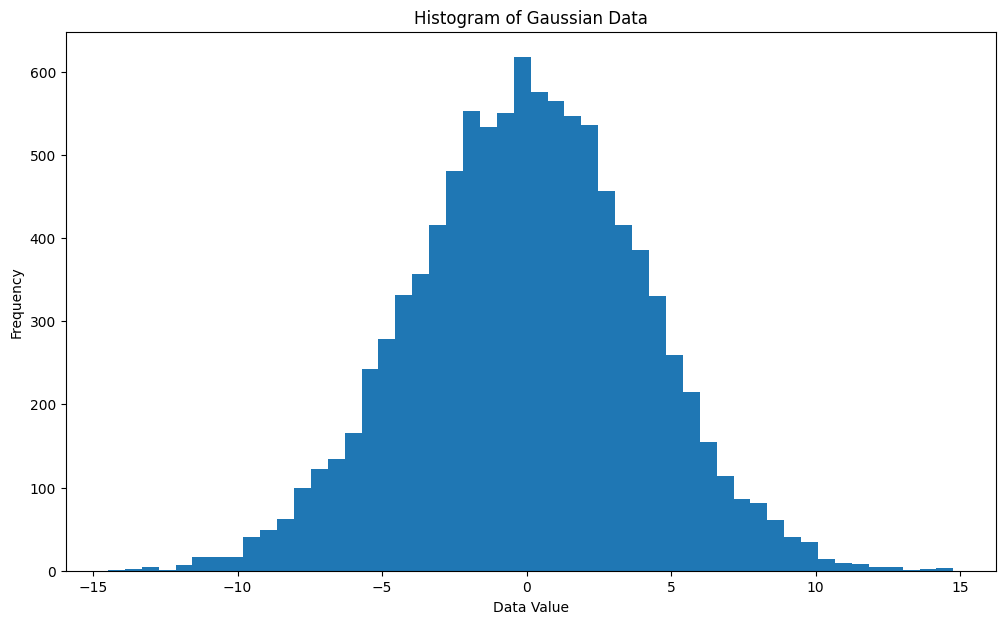

In [ ]:
np.random.seed(10)
# We choose mean ans standard deviation for our normal distribution
mu = 0
sigma = 4
# Make a random sample of 10.000 data points for normal distribution
X = np.random.standard_normal(size=10000) * sigma + mu
# making our histogram
plt.hist(X, bins=50)
plt.title("Histogram of Gaussian Data")
plt.xlabel("Data Value")
plt.ylabel("Frequency")

plt.rcParams["figure.figsize"] = [8, 6]
plt.show()

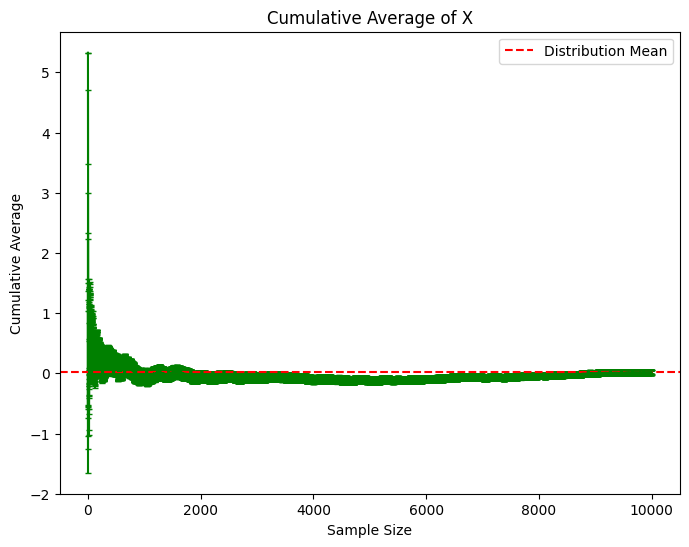

In [ ]:
#Point 3 til 6
cumulative_avg = np.cumsum(X) / np.arange(1, len(X) + 1)
cumulative_error = np.cumsum((X - cumulative_avg) ** 2) / np.arange(1, len(X) + 1)
cumulative_standard_error = np.sqrt(cumulative_error) / np.sqrt(np.arange(1, len(X) + 1))

distribution_mean = np.mean(X) #  (1/N) sum(x_i) 
distribution_median = np.median(X) # (1/N) sum(x_i)

plt.errorbar(np.arange(1, len(X) + 1), cumulative_avg, yerr=cumulative_standard_error, fmt='-', capsize=2,color='green')
plt.axhline(y=distribution_mean, color='red', linestyle='--', label='Distribution Mean')

plt.xlabel('Sample Size')
plt.ylabel('Cumulative Average')
plt.title('Cumulative Average of X')
plt.legend()
plt.rcParams["figure.figsize"] = [12, 7]
plt.show()


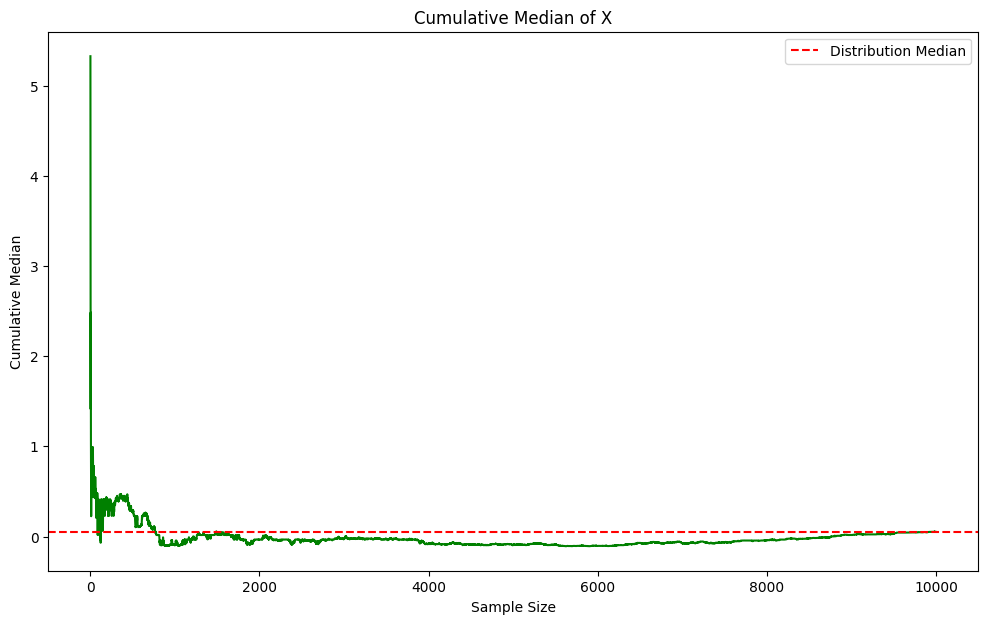

In [ ]:
#Point 7 til 8
cumulative_median = np.zeros(len(X))
for i in range(len(X)):
    cumulative_median[i] = np.median(X[:i+1])

plt.plot(np.arange(1, len(X) + 1), cumulative_median, '-',color="green")
plt.axhline(y=distribution_median, color='r', linestyle='--', label='Distribution Median')
plt.xlabel('Sample Size')
plt.ylabel('Cumulative Median')
plt.title('Cumulative Median of X')
plt.legend()
plt.show()

# Pareto Distribution

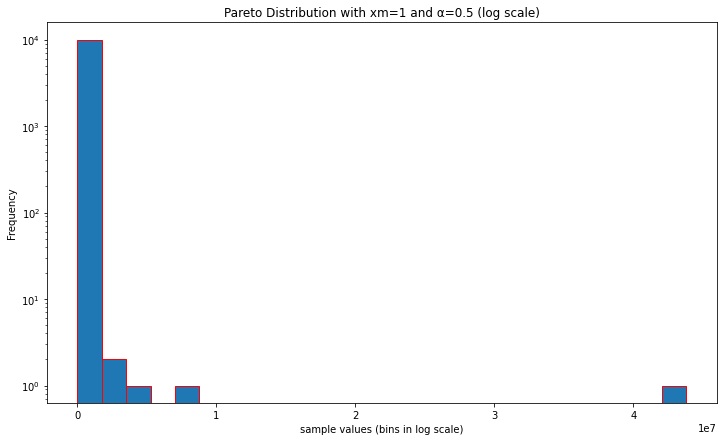

In [68]:
#Point 9 until 10
np.random.seed(9)
#Pareto distribution
xm = 1 #mode
alpha = 0.5 #shape
bin_num = 25

Pareto_data = (np.random.pareto(alpha, size=10000) + 1) * xm
#Pareto_data = np.random.pareto(alpha, size=10000) + xm - 1 both methods seem to work
#plt.hist(Pareto_data, bins=300, log=True) # , log=True)

plt.hist(Pareto_data, bins = bin_num, ec="red") # np.logspace(np.log10(1),np.log10(np.max(30000)),bin_num),ec="red")
#plt.yscale('log')
plt.yscale('log')

plt.title("Pareto Distribution with xm=1 and α=0.5 (log scale)")
plt.xlabel("sample values (bins in log scale)")
plt.ylabel("Frequency")
#plt.ylabel("Frequency (log scale)")
plt.show()


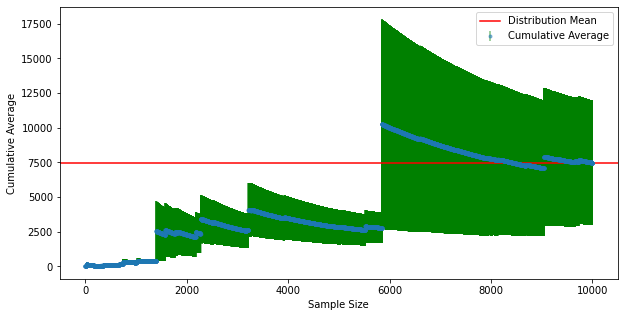

In [52]:
cumulative_avg_Par = np.cumsum(Pareto_data) / np.arange(1, len(Pareto_data) + 1)
cumulative_error_Par = np.cumsum((Pareto_data - cumulative_avg_Par) ** 2) / np.arange(1, len(Pareto_data) + 1)
cumulative_standard_error_Par = np.sqrt(cumulative_error_Par) / np.sqrt(np.arange(1, len(Pareto_data) + 1)) # (approximated) standard error.

distribution_mean_Par = np.mean(Pareto_data) # alpha*xm/(alpha-1) Theoretical or observed estimators?
distribution_median_Par =np.median(Pareto_data) # xm * (2**(1/alpha)) 
#sample_mean_par = np.mean(Pareto_data)

plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(1, len(Pareto_data)+1), cumulative_avg_Par, yerr=cumulative_standard_error_Par, fmt='.', ecolor='green', alpha=0.5, label='Cumulative Average')
plt.axhline(distribution_mean_Par, color='r', label='Distribution Mean')
plt.xlabel('Sample Size')
plt.ylabel('Cumulative Average')
plt.legend()
plt.show()
#Graph makes sense, when taking the distribution into account. There are times when we sample a lucky observation (at around 1700, 2200, 3200 and 5800).

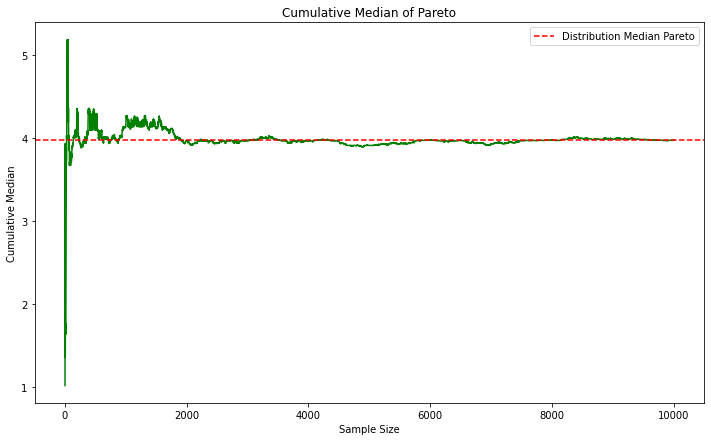

In [53]:
#Point 7 till 8
cumulative_median_pareto = np.zeros(len(Pareto_data))
for i in range(len(Pareto_data)):
    cumulative_median_pareto[i] = np.median(Pareto_data[:i+1])

plt.plot(np.arange(1, len(Pareto_data) + 1), cumulative_median_pareto, '-',color="green")
plt.axhline(y=distribution_median_Par, color='r', linestyle='--', label='Distribution Median Pareto')
plt.xlabel('Sample Size')
plt.ylabel('Cumulative Median')
plt.title('Cumulative Median of Pareto')
plt.legend()
plt.show() # The median is very low compared to mean, since ~99% we sample low numbers 
           #  and while the mean might be pushed up by a single lucky number, when we are calculating median, we only look at quantiles.

# LogNormal Distribution

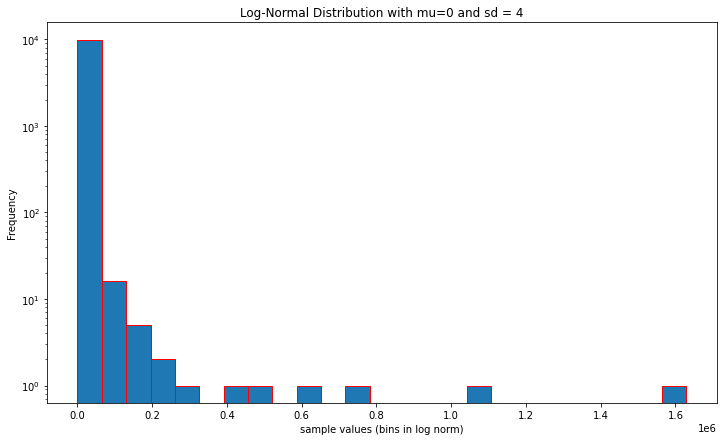

In [69]:
np.random.seed(8)
# We choose mean ans standard deviation for our normal distribution
mu = 0
sigma = 4
bin_num = 25
# Make a random sample of 10.000 data points for normal distribution
X_log = np.exp(np.random.standard_normal(size=10000) * sigma + mu) # np.random.lognormal(sigma=4,size=10000) #
# making our histogram
plt.hist(X_log, bins = bin_num,ec="red") #)np.logspace(np.log10(1),np.log10(np.max(100000)),bin_num),ec="red")
#plt.hist(X_log, bins = 100,log = True)
plt.yscale('log')
plt.title("Log-Normal Distribution with mu=0 and sd = 4")
plt.xlabel("sample values (bins in log norm)")
plt.ylabel("Frequency")
#plt.ylabel("Frequency (log scale)")
plt.show()


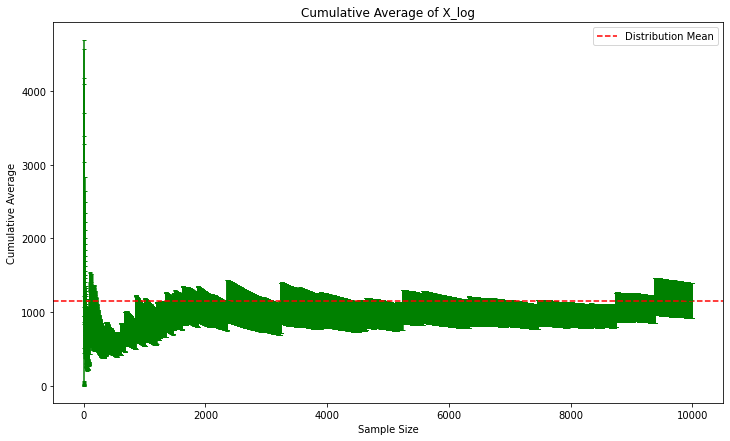

In [48]:
#Point 3 till 6
cumulative_avg_log = np.cumsum(X_log) / np.arange(1, len(X_log) + 1)
cumulative_error_log = np.cumsum((X_log - cumulative_avg_log) ** 2) / np.arange(1, len(X_log) + 1)
cumulative_standard_error_log = np.sqrt(cumulative_error_log) / np.sqrt(np.arange(1, len(X_log) + 1))

distribution_mean_log = np.mean(X_log) #np.exp((4**2)/2) #np.exp(np.mean(X_log) + (np.std(X_log)**2)/2) #np.mean(X_log) #  (1/N) sum(x_i) 
distribution_median_log = np.exp(0) #np.exp(np.mean(X_log))#np.median(X_log) # (1/N) sum(x_i)

plt.errorbar(np.arange(1, len(X_log) + 1), cumulative_avg_log, yerr=cumulative_standard_error_log, fmt='-', capsize=2,color='green')
plt.axhline(y=distribution_mean_log, color='red', linestyle='--', label='Distribution Mean')

plt.xlabel('Sample Size')
plt.ylabel('Cumulative Average')
plt.title('Cumulative Average of X_log')
plt.legend()
plt.rcParams["figure.figsize"] = [12, 7]
plt.show() 

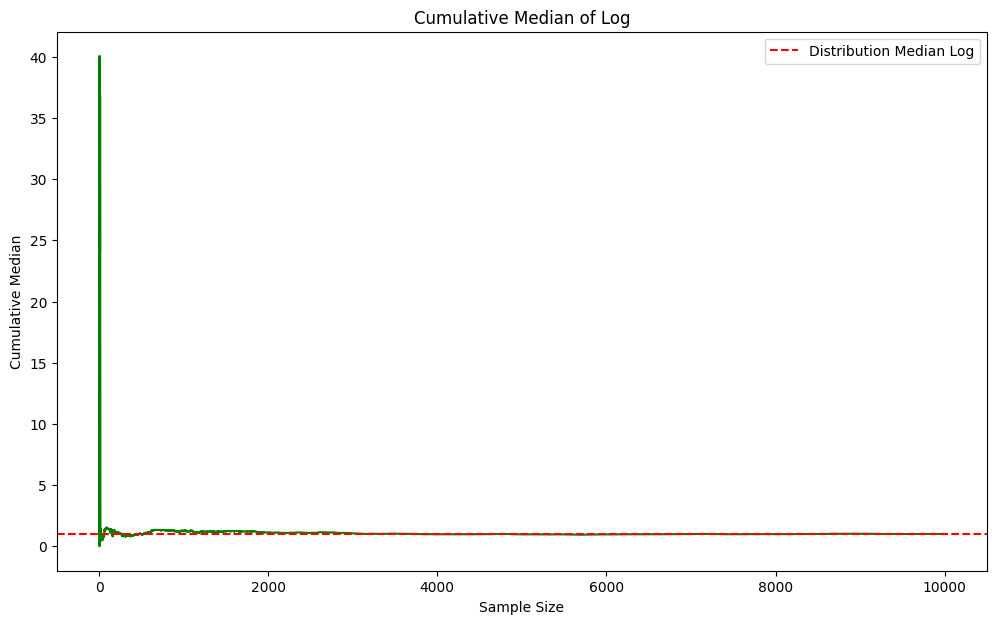

In [ ]:
#Point 7 till 8
cumulative_median_log = np.zeros(len(X_log))
for i in range(len(X_log)):
    cumulative_median_log[i] = np.median(X_log[:i+1])

plt.plot(np.arange(1, len(X_log) + 1), cumulative_median_log, '-',color="green")
plt.axhline(y=distribution_median_log, color='r', linestyle='--', label='Distribution Median Log')
plt.xlabel('Sample Size')
plt.ylabel('Cumulative Median')
plt.title('Cumulative Median of Log')
plt.legend()
plt.show() # The median is very low compared to mean, since ~99% we sample low numbers 
           #  and while the mean might be pushed up by a single lucky number, when we are calculating median, we only look at quantiles.

# Paper Dataset

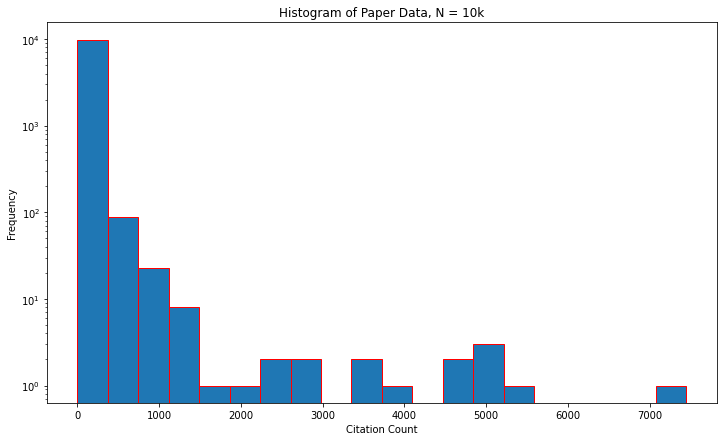

In [70]:
X_paper = np.random.choice(paper_df['citationCount'], size = 10000)
# making our histogram
#plt.hist(x_data, bins=50)
bin_num = 20
plt.hist(X_paper, bins = bin_num, ec="red") #np.logspace(np.log10(1),np.log10(np.max(X_paper)),bin_num),ec="red")
#plt.yscale('log')
plt.yscale('log')


plt.title("Histogram of Paper Data, N = 10k")
plt.xlabel("Citation Count")
plt.ylabel("Frequency")



plt.rcParams["figure.figsize"] = [12, 7]
plt.show()

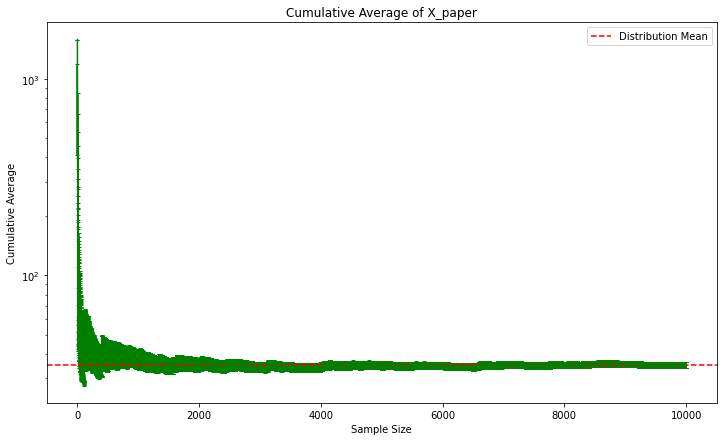

In [58]:
#Point 3 till 6
cumulative_avg_paper = np.cumsum(X_paper) / np.arange(1, len(X_paper) + 1)
cumulative_error_paper = np.cumsum((X_paper - cumulative_avg_paper) ** 2) / np.arange(1, len(X_paper) + 1)
cumulative_standard_error_paper = np.sqrt(cumulative_error_paper) / np.sqrt(np.arange(1, len(X_paper) + 1))

distribution_mean_paper = np.mean(X_paper) #np.exp(np.mean(X_log) + (np.std(X_log)**2)/2) #np.mean(X_log) #  (1/N) sum(x_i) 
distribution_median_paper = np.median(X_paper) #np.exp(np.mean(X_log))#np.median(X_log) # (1/N) sum(x_i)

plt.errorbar(np.arange(1, len(X_paper) + 1), cumulative_avg_paper, yerr=cumulative_standard_error_paper, fmt='-', capsize=2,color='green')
plt.axhline(y=distribution_mean_paper, color='red', linestyle='--', label='Distribution Mean')

plt.xlabel('Sample Size')
plt.ylabel('Cumulative Average')
plt.yscale('log')
plt.title('Cumulative Average of X_paper')
plt.legend()
plt.rcParams["figure.figsize"] = [12, 7]
plt.show() 

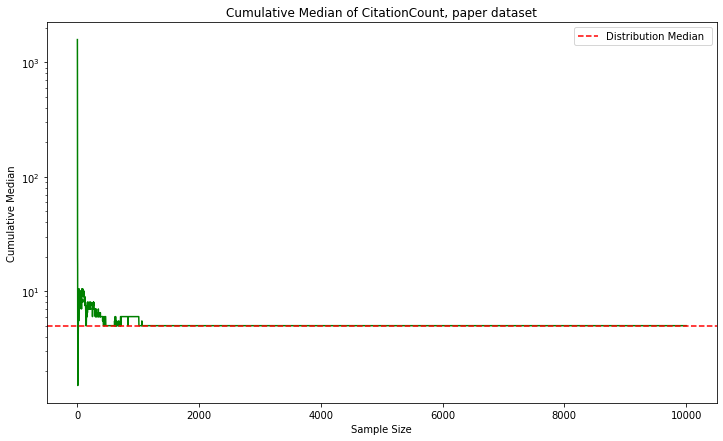

In [59]:
#Point 7 till 8
cumulative_median_paper = np.zeros(len(X_paper))
for i in range(len(X_paper)):
    cumulative_median_paper[i] = np.median(X_paper[:i+1])

plt.plot(np.arange(1, len(X_paper) + 1), cumulative_median_paper, '-',color="green")
plt.axhline(y=distribution_median_paper, color='r', linestyle='--', label='Distribution Median ')
plt.xlabel('Sample Size')
plt.ylabel('Cumulative Median')
plt.yscale('log')
plt.title('Cumulative Median of CitationCount, paper dataset')
plt.legend()
plt.show() # The median is very low compared to mean, since ~99% we sample low numbers 
           #  and while the mean might be pushed up by a single lucky number, when we are calculating median, we only look at quantiles.

# Svar på spørgsmål

## Question 1

Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution. What do you observe? Would you expect these results? Why?

*   The uncertainty of our estimator for the sample mean decreases monotonically, as variance falls with number of samples for the Gaussian Distribution. 
*   Meanwhile, the uncertainty of the Pareto Distribution increases with more samples and this makes sense because the Pareto distribution has very long tails (there is a low but feasible chance that 500,000 is sampled) and thus the Pareto distribution might return a very high value which makes it difficult to estimate the true scale and shape of the Pareto distribution. Using the plot, we can see that this happens at around 1700, 2200, 3200 and 5800 sample.

*    As the higher values in the tail are added, the Pareto and LogNormal distributions cumulative averages first rise quickly but later start to climb more slowly.

* The cumulative average slows down more noticeably as compared to the LogNormal distribution because the Pareto distribution has a significantly bigger tail.

- We would expect does results since it represents the properties of their distributions. Gaussian distribution has a round curve and is symmetric around the mean which makes the avrerage increase slowly and monotonically. Pareto distribution is heavily skewed towards the start which makes the average increase rapidly at first and then slows down. LogNormal distribution is close to Pareto distribution but is less skewed, resulting in a less pronounced slowing down of the cumulative average.

## Question 2

Compare the cumulative median vs the cumulative average for the three previous distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more useful in the different cases?



- Both the cumulative average and median graphs look the same and move smoothly and monotonically without any changes, they are close to the same graph. 
- Both the cumulative average and median graphs for Pareto and LogNormal look completely different, which shows that their can be a totally different interpretation of the data. 

- The conclusions we can draw are that for the Gaussian distribution, the mean and median are very close to each other so they would both be useful for statistics. As for the other two distributions, since they have long tails and extreme values, the median would be more useful since it isn't as sensitive to extreme values.

## Question 3

* We observe that our sample estimators for the variance (which is proportional with standard error) of the mean and the median decrease as the sample count increases. While the variance of the median can not be seen in the plot, we see that the cumulative median converges to a specific number, so it seems like we can also be certain of our approximation of our sample median of the citationCount distribution for our paper dataset. This means that we will get a better estimate of the expected citationcount of papers by sampling and that the underlying distribution does not have heavy tails.

## Question 4

*  That data we sample in the real-world follow a underlying distribution, which we try to describe using parameter estimators. These estimators do not nessecarily increase with number of samples if the underlying distribution is very skewed, e.g. a pareto distribution and that depending on what underlying distribution, which our dataset follows, then this will be expressed when we sample our datapoints. 

* While Multiple distributions may have good 'fitness' of a dataset, we have to take into consideration that different distributions have different assumptions. For example, a Gaussian allows for sampling negative citationcounts.